# **Loan Success Prediction**

- **GROUP DETAILS**
    - GROUP: _Group 7_
    - AUTHORS: _Mrunal Dalvi, Abhiroop Kumar, Emily Lagnese, Keerti Rawat_

- **COURSE DETAILS**
    - COURSE: _Data Science Programming (MIS 381N)_
    - CLASS: _71585_
    - SEMESTER: _SUMMER 2025_
    - PROFESSOR: _Deepayan Chakrabarti_
    - SUBMISSION DUE: _Aug 11 at 10am_

- **VERSIONING DETAILS**
    - LAST UPDATED BY: _Abhiroop Kumar_
    - LAST UPDATED DATE: _Aug 26_
    - LAST UPDATE MESSAGE: _File modified for Git Push_

---

In [116]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve


---

1. Data Loading and Target Variable Creation

In [117]:
# Path to dataset
file_504 = 'foia-504-fy2010-present-asof-250630.csv'
file_7a = 'foia-7a-fy2020-present-asof-250630.csv'

# Load dataset
try:
    df_504 = pd.read_csv(file_504, low_memory=False)
    df_7a = pd.read_csv(file_7a, low_memory=False)
    print("Datasets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure both files are in the same directory.")
    exit()

# Remove data before 2020 in the 'df_504' Data Frame
df_504['ApprovalDate'] = pd.to_datetime(df_504['ApprovalDate'], errors='coerce')
df_504['Year'] = df_504['ApprovalDate'].dt.year
filtered_df_504 = df_504[df_504['Year'] >= 2020].copy()

# Get columns from each Df
cols_504 = set(filtered_df_504.columns)
cols_7a = set(df_7a.columns)

# Find common and different columns
common_columns = sorted(list(cols_504.intersection(cols_7a)))
cols_only_in_504 = sorted(list(cols_504.difference(cols_7a)))
cols_only_in_7a = sorted(list(cols_7a.difference(cols_504)))

print("\nCommon columns:")
print(common_columns)
print("\nColumns only in the 504 dataset:")
print(cols_only_in_504)
print("\nColumns only in the 7a dataset:")
print(cols_only_in_7a)


# Standardize Column Names before Merging

# Create a dictionary to map column names from filtered_df_504 to df_7a
# The keys are old column names from filtered_df_504, and values are the new names
rename_cols = {
    'TermInMonths': 'TerminMonths',
    'NaicsCode': 'NAICSCode',
    'NaicsDescription': 'NAICSDescription',
    'PaidInFullDate': 'PaidinFullDate',
    'ChargeOffDate': 'ChargeoffDate',
    'GrossChargeOffAmount': 'GrossChargeoffAmount',
    'ApprovalFiscalYear': 'ApprovalFY'
}

# Rename columns in filtered_df_504 using rename_cols
filtered_df_504.rename(columns=rename_cols, inplace=True)

# Display column names of filtered_df_504 after renaming
print("\nColumns in filtered_df_504 after renaming:")
print(filtered_df_504.columns)

# Merge both Dfs
df = pd.concat([filtered_df_504, df_7a], ignore_index=True)

# Display few rows of Df
print("\nFirst 5 rows of dataset:")
print(df.head())

# Display basic information about Df
print("\nDataFrame Info:")
df.info()

# Display descriptive statistics for numerical columns
print("\nDescriptive statistics of numerical columns:")
print(df.describe())

# Save merged Df to new CSV file
# df.to_csv("merged_foia_data.csv", index=False)
# print("\nMerged data saved to merged_foia_data.csv")


Datasets loaded successfully.

Common columns:
['ApprovalDate', 'AsOfDate', 'BorrCity', 'BorrName', 'BorrState', 'BorrStreet', 'BorrZip', 'BusinessAge', 'BusinessType', 'CollateralInd', 'CongressionalDistrict', 'FirstDisbursementDate', 'FranchiseCode', 'FranchiseName', 'GrossApproval', 'JobsSupported', 'LoanStatus', 'LocationID', 'ProcessingMethod', 'Program', 'ProjectCounty', 'ProjectState', 'SBADistrictOffice', 'Subprogram']

Columns only in the 504 dataset:
['ApprovalFiscalYear', 'CDC_City', 'CDC_Name', 'CDC_State', 'CDC_Street', 'CDC_Zip', 'ChargeOffDate', 'GrossChargeOffAmount', 'NaicsCode', 'NaicsDescription', 'PaidInFullDate', 'TermInMonths', 'ThirdPartyDollars', 'ThirdPartyLender_City', 'ThirdPartyLender_Name', 'ThirdPartyLender_State', 'Year']

Columns only in the 7a dataset:
['ApprovalFY', 'BankCity', 'BankFDICNumber', 'BankNCUANumber', 'BankName', 'BankState', 'BankStreet', 'BankZip', 'ChargeoffDate', 'FixedorVariableInterestRate', 'GrossChargeoffAmount', 'InitialInterestRat

In [118]:
# Create response variable 'LoanSuccess'
# In 'LoanStatus' column, we will take 'PIF' as success and 'CHGOFF' as default. Other statuses will be removed from analysis


# Filter Df to include only 'PIF' and 'CHGOFF' statuses
df_filtered = df[df['LoanStatus'].isin(['PIF', 'CHGOFF'])].copy()

# Create 'LoanSuccess' column:
# 'PIF' = 0, for successful repayment ; 'CHGOFF' = 1, for loan default
df_filtered['LoanSuccess'] = df_filtered['LoanStatus'].map({'PIF': 0, 'CHGOFF': 1})

# Verify creation of new column
print(f"\nShape of dataset after filtering LoanStatus: {df_filtered.shape}")
print("\nValue counts for new 'LoanSuccess' column:")
print(df_filtered['LoanSuccess'].value_counts())
print("\nValue counts for original 'LoanStatus' column after filtering:")
print(df_filtered['LoanStatus'].value_counts())



Shape of dataset after filtering LoanStatus: (52181, 54)

Value counts for new 'LoanSuccess' column:
LoanSuccess
0    48377
1     3804
Name: count, dtype: int64

Value counts for original 'LoanStatus' column after filtering:
LoanStatus
PIF       48377
CHGOFF     3804
Name: count, dtype: int64


---

2. Data Preprocessing

Note: I've modified the data removal of the row-wise elimination of empty values, because it cut down the row count from by a large margin. As such, I've changed the _Stage 2_ by replacing the empty values as follows:
- Empty values in the numerical columns will be replaced with `0` (an empty value in a numerical column essentialy equates to zero)
- Empty values of the categorical columns (text values) will be replaced with `Missing` (the `Missing` values can be removed when plotting graphs later on)

In [119]:
# Missing Value Imputation: Two-Stage Approach

# Stage 1: Column-wise Removal (Features with >70% Missing Values)
print("Stage 1: Removing columns with more than 70% missing values")

# Calculate percentage of missing values for each column
missing_percentages = df_filtered.isnull().sum() / len(df_filtered) * 100

# Identify columns to drop (> 70% threshold)
columns_to_drop_high_missing = missing_percentages[missing_percentages > 70].index.tolist()

print(f"Columns with >70% missing values to be dropped: {columns_to_drop_high_missing}")
print(f"Number of columns to be dropped in Stage 1: {len(columns_to_drop_high_missing)}")

# Drop identified columns from Df
df_processed = df_filtered.drop(columns=columns_to_drop_high_missing, axis=1)
print(f"Shape of dataset after Stage 1 (column removal): {df_processed.shape}")


# Stage 2: Addition of 'sample' data
# To avoid dropping any rows, missing numerical values will be replaced with 0, and missing categorical values will be replaced with string value "Missing"
print("\nStage 2: Addition of 'sample' data")

# Identify numerical and categorical columns
numerical_cols = df_processed.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df_processed.select_dtypes(include='object').columns.tolist()

# Exclude response variable from numerical columns for imputation
if 'LoanSuccess' in numerical_cols:
    numerical_cols.remove('LoanSuccess')

# Impute missing values in numerical columns with 0
df_processed[numerical_cols] = df_processed[numerical_cols].fillna(0)
print(f"Filled missing values in numerical columns with 0: {numerical_cols}")

# Impute missing values in categorical columns with 'Missing'
df_processed[categorical_cols] = df_processed[categorical_cols].fillna('Missing')
print(f"Filled missing values in categorical columns with 'Missing': {categorical_cols}")

# Drop NaN and empty string values from 'BusinessType'
df_filtered = df_processed[df_processed['BusinessType'].notna()]
df_filtered = df_filtered[df_filtered['BusinessType'].str.strip() != '']

print(f"\nFinal shape of the dataset after missing value imputation: {df_filtered.shape}")

# Verify that there are no more missing values
print("\nMissing values after two-stage imputation (should be all zeros):", df_filtered.isnull().sum().sum()) # Sum of all missing values in the DataFrame


Stage 1: Removing columns with more than 70% missing values
Columns with >70% missing values to be dropped: ['CDC_Name', 'CDC_Street', 'CDC_City', 'CDC_State', 'CDC_Zip', 'ThirdPartyLender_Name', 'ThirdPartyLender_City', 'ThirdPartyLender_State', 'ThirdPartyDollars', 'FranchiseCode', 'FranchiseName', 'ChargeoffDate', 'Year', 'BankNCUANumber']
Number of columns to be dropped in Stage 1: 14
Shape of dataset after Stage 1 (column removal): (52181, 40)

Stage 2: Addition of 'sample' data
Filled missing values in numerical columns with 0: ['BorrZip', 'LocationID', 'GrossApproval', 'ApprovalFY', 'TerminMonths', 'NAICSCode', 'CongressionalDistrict', 'GrossChargeoffAmount', 'JobsSupported', 'BankFDICNumber', 'BankZip', 'SBAGuaranteedApproval', 'InitialInterestRate', 'RevolverStatus']
Filled missing values in categorical columns with 'Missing': ['AsOfDate', 'Program', 'BorrName', 'BorrStreet', 'BorrCity', 'BorrState', 'ApprovalDate', 'FirstDisbursementDate', 'ProcessingMethod', 'Subprogram', 'N

In [120]:
# Feature Exclusion
# Exclude features that are direct outcomes/consequences of LoanStatus or are high textual data that will increase complexity of model prediction

# LoanStatus Outcomes Features: These features would only be available after loan status is known, making them unsuitable for prediction
loan_status_outcomes = [
    'PaidinFullDate', 'ChargeoffDate', 'GrossChargeoffAmount'
]

# High Complexity Features: These are identifiers with high textual data. Including them directly will drastically increase the complexity, which can lead to overfitting
high_complexity_features = [
    'BorrStreet', 'BorrCity', 'BorrZip', 'BankStreet', 'BankCity', 'BankZip', 'CDC_Street', 'CDC_City', 'CDC_Zip', 'ThirdPartyLender_City', 'LocationID', 'BankFDICNumber', 'BankNCUANumber', 'FranchiseCode', 'FranchiseName', 'ProjectCounty', 'ProjectState', 'SBADistrictOffice', 'CongressionalDistrict', 'NaicsDescription', 'AsOfDate', 'ApprovalDate', 'FirstDisbursementDate', 'Year'
]

# Combine all features to exclude
features_to_exclude = list(set(loan_status_outcomes + high_complexity_features))

# Filter out only those features that actually exist in the current Df (some might have been dropped already in the missing value imputation stage)
existing_features_to_exclude = [col for col in features_to_exclude if col in df_filtered.columns]

print(f"Feature Exclusion")
print(f"Features identified for exclusion: {existing_features_to_exclude}")

# Drop identified features from Df
df_final = df_filtered.drop(columns=existing_features_to_exclude, axis=1)
print(f"Shape of dataset after excluding specified features: {df_final.shape}")

# Ensure 'LoanStatus' is also dropped as we have 'LoanSuccess'
if 'LoanStatus' in df_final.columns:
    df_final.drop(columns=['LoanStatus'], inplace=True)
    print("\nDropped 'LoanStatus' column as 'LoanSuccess' is the response variable")
print(f"Final shape before EDA and Feature Engineering: {df_final.shape}")


Feature Exclusion
Features identified for exclusion: ['ProjectState', 'ApprovalDate', 'BankZip', 'BorrCity', 'GrossChargeoffAmount', 'BorrStreet', 'CongressionalDistrict', 'BankFDICNumber', 'BorrZip', 'SBADistrictOffice', 'BankStreet', 'LocationID', 'FirstDisbursementDate', 'ProjectCounty', 'BankCity', 'PaidinFullDate', 'AsOfDate']
Shape of dataset after excluding specified features: (52178, 23)

Dropped 'LoanStatus' column as 'LoanSuccess' is the response variable
Final shape before EDA and Feature Engineering: (52178, 22)


2. (a) Exploratory Data Analysis [EDA]

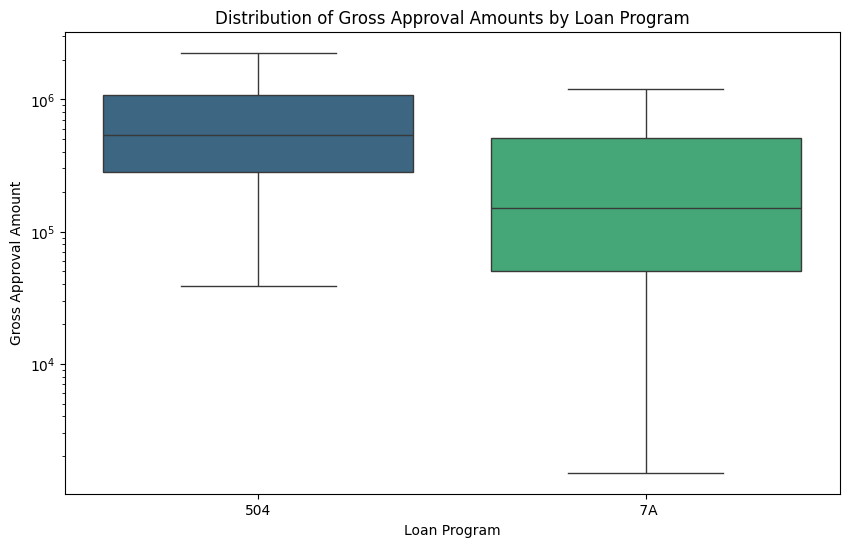

Observation: 504 loans tend to have higher approval amounts than 7(a) loans


In [121]:
# Illustrate Loan Approval Amounts by Program
plt.figure(figsize=(10, 6))
sns.boxplot(x='Program', y='GrossApproval', data=df_final, palette='viridis', hue='Program', legend=False, showfliers=False)
plt.title('Distribution of Gross Approval Amounts by Loan Program')
plt.xlabel('Loan Program')
plt.ylabel('Gross Approval Amount')
plt.yscale('log') # Use log scale to handle wide range of values
plt.show()
print("Observation: 504 loans tend to have higher approval amounts than 7(a) loans")


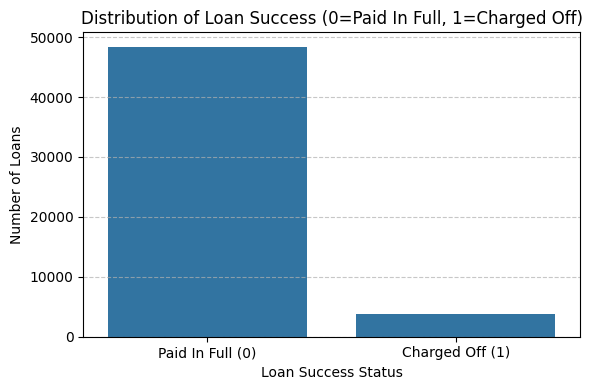


Observed Class Imbalance: The number of 'Paid In Full' loans significantly outnumbers 'Charged Off' loans
This is a common characteristic of loan default datasets, reflecting a healthy lending portfolio


In [122]:
# Check distribution of response variable 'LoanSuccess' (to understand class imbalance)
plt.figure(figsize=(6, 4))
sns.countplot(x='LoanSuccess', data=df_final)
plt.title('Distribution of Loan Success (0=Paid In Full, 1=Charged Off)')
plt.xlabel('Loan Success Status')
plt.ylabel('Number of Loans')
plt.xticks(ticks=[0, 1], labels=['Paid In Full (0)', 'Charged Off (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("\nObserved Class Imbalance: The number of 'Paid In Full' loans significantly outnumbers 'Charged Off' loans")
print("This is a common characteristic of loan default datasets, reflecting a healthy lending portfolio")


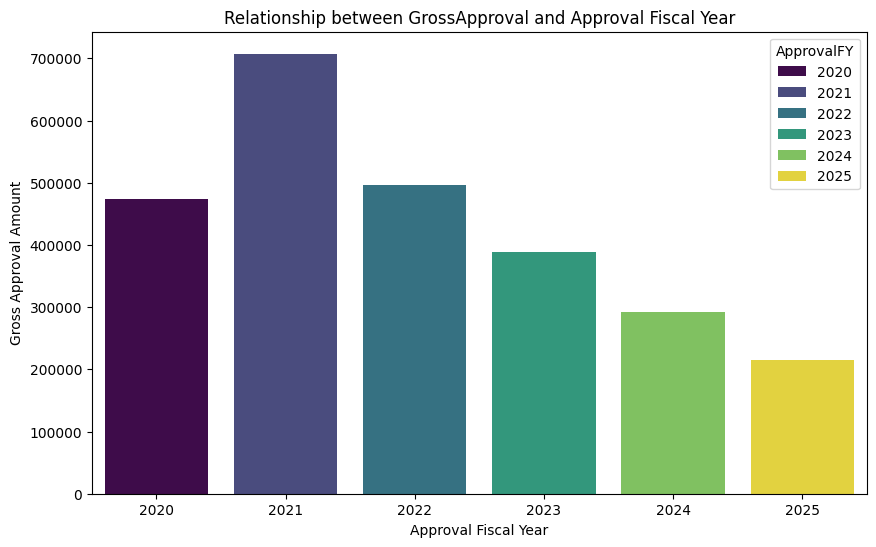

Observation: In 2021, lender have provided the maximum amount to small businesses


In [123]:
# Check the relationship between GrossApproval and Approval Fiscal Year (Bar Chart)
plt.figure(figsize=(10, 6))
sns.barplot(x='ApprovalFY', y='GrossApproval', data=df_final, palette='viridis', errorbar=None, hue='ApprovalFY')
plt.title('Relationship between GrossApproval and Approval Fiscal Year')
plt.xlabel('Approval Fiscal Year')
plt.ylabel('Gross Approval Amount')
plt.show()
print("Observation: In 2021, lender have provided the maximum amount to small businesses")


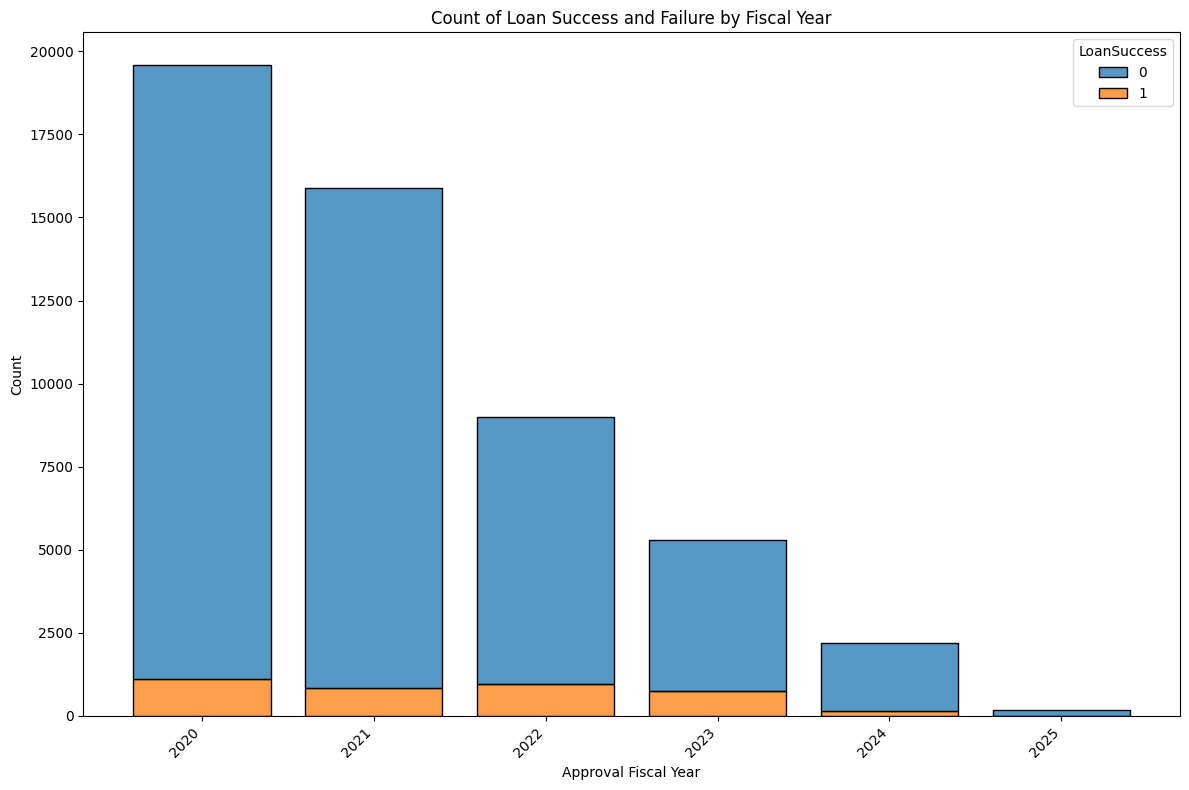

In [124]:
# Stacked bar chart to show the count of successful and unsuccessful loans per year
plt.figure(figsize=(12, 8))
sns.histplot(data=df_final, x='ApprovalFY', hue='LoanSuccess', multiple='stack', shrink=0.8, discrete=True)
plt.title('Count of Loan Success and Failure by Fiscal Year')
plt.xlabel('Approval Fiscal Year')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3. Feature Engineering

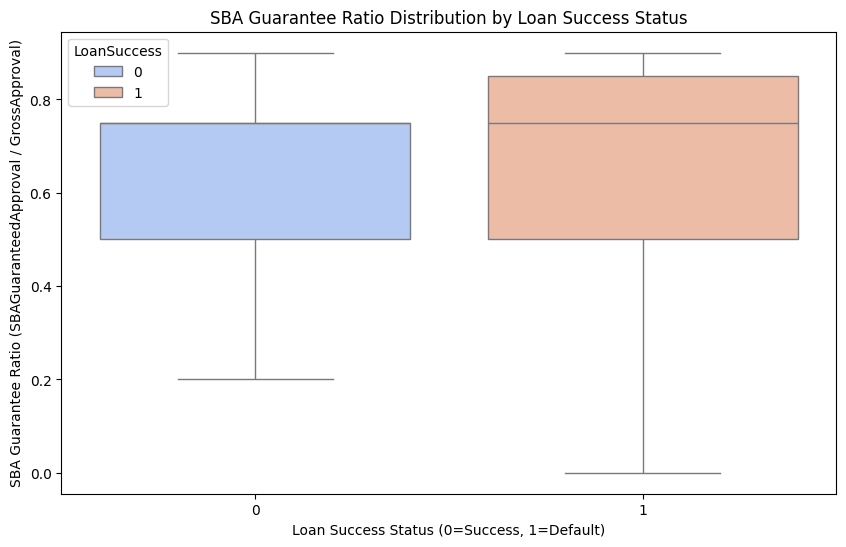

Observation: The plot shows the box for defaulted loans is larger, which means the SBA Guarantee ratios for the central 50% of these loans are more spread out compared to the successful loans.
This difference in the data's spread still suggests the ratio could be a useful predictor.


In [125]:
# SBA Guarantee Ratio: SBAGuaranteedApproval / GrossApproval
df_final['SBA_Guarantee_Ratio'] = np.where(df_final['GrossApproval'] != 0, df_final['SBAGuaranteedApproval'] / df_final['GrossApproval'], 0) # assign 0 if GrossApproval is 0 to avoid inf/NaN

# SBA Guarantee Ratio Justification (Box Plot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='LoanSuccess', y='SBA_Guarantee_Ratio', data=df_final, palette='coolwarm', showfliers=False, hue='LoanSuccess')
plt.title('SBA Guarantee Ratio Distribution by Loan Success Status')
plt.xlabel('Loan Success Status (0=Success, 1=Default)')
plt.ylabel('SBA Guarantee Ratio (SBAGuaranteedApproval / GrossApproval)')
plt.show()
print("Observation: The plot shows the box for defaulted loans is larger, which means the SBA Guarantee ratios for the central 50% of these loans are more spread out compared to the successful loans.\nThis difference in the data's spread still suggests the ratio could be a useful predictor.")


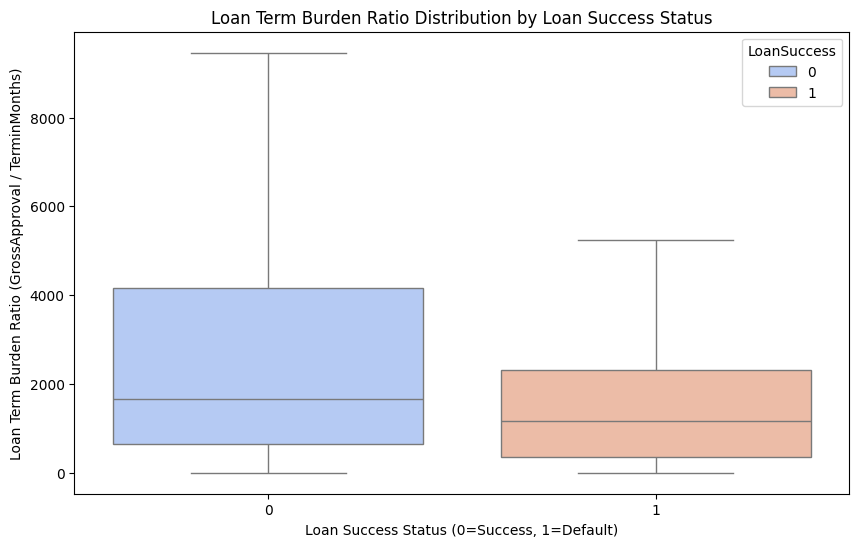

Observation: The graph shows that the median Loan Term Burden Ratio (line inside the box) is higher for successful loans (0) compared to defaulted loans (1).
The central 50% of successfull loans (represented by the box) have a higher burden ratio than the that of the defaulted loans.
This clear separation in medians and distributions suggests that loans with a higher burden ratios are more likely to be successfully repaid.


In [126]:
# Loan Term Burden Ratio: GrossApproval / TermInMonths
df_final['Loan_Term_Burden_Ratio'] = np.where(df_final['TerminMonths'] != 0, df_final['GrossApproval'] / df_final['TerminMonths'], 0) # assign 0 if TerminMonths is 0

# Loan Term Burden Ratio Justification (Box Plot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='LoanSuccess', y='Loan_Term_Burden_Ratio', data=df_final, palette='coolwarm', showfliers=False, hue='LoanSuccess')
plt.title('Loan Term Burden Ratio Distribution by Loan Success Status')
plt.xlabel('Loan Success Status (0=Success, 1=Default)')
plt.ylabel('Loan Term Burden Ratio (GrossApproval / TerminMonths)')
plt.show()
print("Observation: The graph shows that the median Loan Term Burden Ratio (line inside the box) is higher for successful loans (0) compared to defaulted loans (1).\nThe central 50% of successfull loans (represented by the box) have a higher burden ratio than the that of the defaulted loans.\nThis clear separation in medians and distributions suggests that loans with a higher burden ratios are more likely to be successfully repaid.")


<>:14: SyntaxWarning: invalid escape sequence '\A'
<>:14: SyntaxWarning: invalid escape sequence '\A'
C:\Users\Abhiroop Kumar\AppData\Local\Temp\ipykernel_3484\670748623.py:14: SyntaxWarning: invalid escape sequence '\A'
  print("Observation: The box plot shows differences in the distribution of the Jobs Impact Efficiency Ratio between successful loans (0) and defaulted loans (1).\nThe median ratio (line inside the box) for successful loans is higher than for defaulted loans.\Also, the box for defaulted loans is positioned at a lower range of values on the y-axis, indicating that the central 50% of these loans have a lower efficiency ratio compared to successful loans.\nThe box for successful loans is also slightly wider, suggesting more variability within the central half of its distribution. This clear difference in both the median and distributions indicates its value as a predictor.")


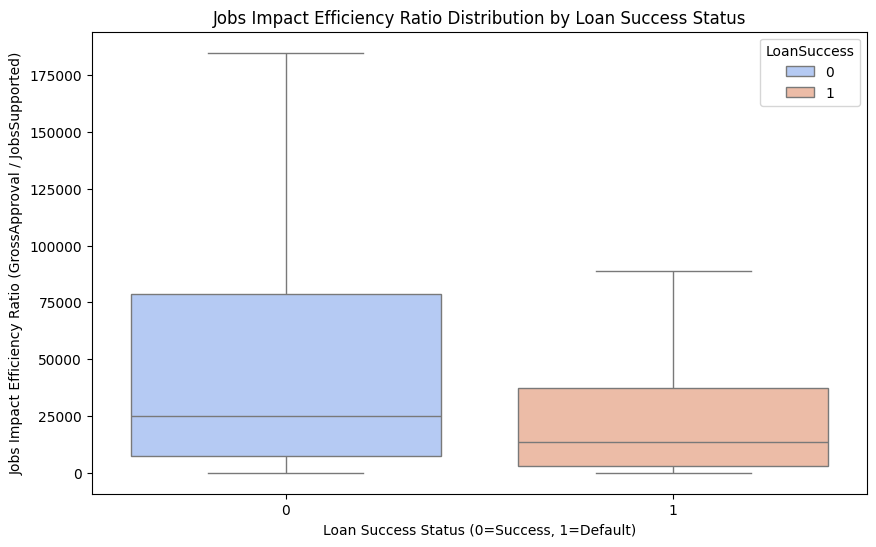

Observation: The box plot shows differences in the distribution of the Jobs Impact Efficiency Ratio between successful loans (0) and defaulted loans (1).
The median ratio (line inside the box) for successful loans is higher than for defaulted loans.\Also, the box for defaulted loans is positioned at a lower range of values on the y-axis, indicating that the central 50% of these loans have a lower efficiency ratio compared to successful loans.
The box for successful loans is also slightly wider, suggesting more variability within the central half of its distribution. This clear difference in both the median and distributions indicates its value as a predictor.


In [127]:
# Small epsilon value to avoid division by 0 for JobsSupported (adding small epsilon for ratios involving division as a safe practice)
epsilon = 1e-6

# Jobs Impact Efficiency Ratio: GrossApproval / JobsSupported
df_final['Jobs_Impact_Efficiency_Ratio'] = np.where(df_final['JobsSupported'] != 0, df_final['GrossApproval'] / (df_final['JobsSupported'] + epsilon), 0) # assign 0 if JobsSupported is 0

# Jobs Impact Efficiency Ratio Justification (Box Plot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='LoanSuccess', y='Jobs_Impact_Efficiency_Ratio', data=df_final, palette='coolwarm', showfliers=False, hue='LoanSuccess')
plt.title('Jobs Impact Efficiency Ratio Distribution by Loan Success Status')
plt.xlabel('Loan Success Status (0=Success, 1=Default)')
plt.ylabel('Jobs Impact Efficiency Ratio (GrossApproval / JobsSupported)')
plt.show()
print("Observation: The box plot shows differences in the distribution of the Jobs Impact Efficiency Ratio between successful loans (0) and defaulted loans (1).\nThe median ratio (line inside the box) for successful loans is higher than for defaulted loans.\Also, the box for defaulted loans is positioned at a lower range of values on the y-axis, indicating that the central 50% of these loans have a lower efficiency ratio compared to successful loans.\nThe box for successful loans is also slightly wider, suggesting more variability within the central half of its distribution. This clear difference in both the median and distributions indicates its value as a predictor.")


In [128]:
# Print new engineered features values
print("\nNew engineered features created:")
print(df_final[['SBA_Guarantee_Ratio', 'Loan_Term_Burden_Ratio', 'Jobs_Impact_Efficiency_Ratio']].head())



New engineered features created:
    SBA_Guarantee_Ratio  Loan_Term_Burden_Ratio  Jobs_Impact_Efficiency_Ratio
26                  0.0             1043.333333                 104333.298556
45                  0.0             2243.333333                 112166.647972
84                  0.0             4900.000000                  39199.998693
86                  0.0             2863.333333                 286333.237889
87                  0.0             3087.500000                  29639.998814


3. (a) Categorical Feature Encoding [One-Hot Encoding]

In [129]:
# List of columns to get unique value count from
columns_to_check = ['Program', 'BorrName', 'BorrState', 'ProcessingMethod', 'Subprogram', 'NAICSDescription', 'BusinessType', 'BusinessAge', 'CollateralInd', 'BankName', 'BankState', 'FixedorVariableInterestRate']

# Get the count of unique values for each specified column
for col in columns_to_check:
    if col in df_final.columns:
        unique_count = df_final[col].nunique()
        print(f"Column '{col}': {unique_count} unique value(s)")
    else:
        print(f"Column '{col}' not found in the DataFrame.")

# Drop columns with high value counts
high_unique_value_counts_columns_to_drop = ['BorrName', 'NAICSDescription', 'BankName']

# Drop the columns from the Df
df_drop = df_final.copy()
df_drop.drop(columns=high_unique_value_counts_columns_to_drop, axis=1, inplace=True)

# Identify categorical columns that need encoding (excluding response variable 'LoanSuccess')
categorical_features_for_encoding = df_drop.select_dtypes(include='object').columns.tolist()

print(f"Categorical features to be One-Hot Encoded: {categorical_features_for_encoding}\n")

# One-Hot Encoding
df_encoded = pd.get_dummies(df_drop, columns=categorical_features_for_encoding, drop_first=True)

print(f"Shape of the dataset after One-Hot Encoding: {df_encoded.shape}")
print(df_encoded.head())
print(df_encoded.shape)

Column 'Program': 2 unique value(s)
Column 'BorrName': 47664 unique value(s)
Column 'BorrState': 54 unique value(s)
Column 'ProcessingMethod': 22 unique value(s)
Column 'Subprogram': 12 unique value(s)
Column 'NAICSDescription': 897 unique value(s)
Column 'BusinessType': 3 unique value(s)
Column 'BusinessAge': 6 unique value(s)
Column 'CollateralInd': 2 unique value(s)
Column 'BankName': 1512 unique value(s)
Column 'BankState': 55 unique value(s)
Column 'FixedorVariableInterestRate': 3 unique value(s)
Categorical features to be One-Hot Encoded: ['Program', 'BorrState', 'ProcessingMethod', 'Subprogram', 'BusinessType', 'BusinessAge', 'CollateralInd', 'BankState', 'FixedorVariableInterestRate', 'SoldSecondMarketInd']

Shape of the dataset after One-Hot Encoding: (52178, 163)
    GrossApproval  ApprovalFY  TerminMonths  NAICSCode  JobsSupported  \
26       313000.0        2020           300   325411.0            3.0   
45       673000.0        2020           300   325620.0            6.0 

# 5. Data Splitting

In [130]:
# Declare features (X) and response (y)
X = df_encoded.drop('LoanSuccess', axis=1) # all columns except 'LoanSuccess'
y = df_encoded['LoanSuccess'] # The response variable

# Split data into 80% training set and 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # 'stratify=y' keeps the proportion of 'LoanSuccess' (0s and 1s) the same in both training and testing sets (required for imbalanced datasets)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

# Verify class distribution in training and test sets
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

Shape of X_train: (41742, 162)
Shape of X_test: (10436, 162)
Shape of y_train: (41742,)
Shape of y_test: (10436,)

Class distribution in training set:
LoanSuccess
0    0.927124
1    0.072876
Name: proportion, dtype: float64

Class distribution in test set:
LoanSuccess
0    0.927175
1    0.072825
Name: proportion, dtype: float64


# 6. Model Development

In [131]:
# Clean X_train & X_test for specific model requirements
X_train.columns = [str(c).replace('[', '(').replace(']', ')').replace('<', '') for c in X_train.columns]
X_test.columns = [str(c).replace('[', '(').replace(']', ')').replace('<', '') for c in X_test.columns]

In [132]:
# Logistic Regression

# Take a smaller subset of the training set for faster modeling
X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train, 
    train_size=0.2,   # Only 20% of the training set → ~13k rows
    random_state=42, 
    stratify=y_train
)

# Second split: Train (80%), Validation (20%) from the smaller set
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_small, y_train_small,
    test_size=0.2,
    random_state=42,
    stratify=y_train_small
)

# You can now fit your model on X_train_final instead of full X_train

print(f"Shape of X_train (Split): {X_train_final.shape}")
print(f"Shape of X_test (Split): {X_val.shape}")
print(f"Shape of y_train (Split): {y_train_final.shape}")
print(f"Shape of y_test (Split): {y_val.shape}")

lm_model = LogisticRegression(solver='saga', max_iter=1000)
lm_model.fit(X_train_final, y_train_final)

lm_pred = lm_model.predict(X_val)

Shape of X_train (Split): (6678, 162)
Shape of X_test (Split): (1670, 162)
Shape of y_train (Split): (6678,)
Shape of y_test (Split): (1670,)


c:\Users\Abhiroop Kumar\miniconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [133]:
# Random Forest

# Initialize Random Forest Classifier and fit model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Test set prediction
rf_pred = rf_model.predict(X_test)


In [134]:
# XGBoost

xgb_model = xgb.XGBClassifier(use_label_encoder=True, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
xgb_pred = xgb_model.predict(X_test)

c:\Users\Abhiroop Kumar\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:44:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# 7. Model Development (with Weights)

In [135]:
# Logistic Regression

# Add class_weight='balanced' to handle class imbalance 
lm_model_weights = LogisticRegression(solver='saga', max_iter=1000, class_weight='balanced', random_state=42)

lm_model_weights.fit(X_train_final, y_train_final)

lm_pred_weights = lm_model_weights.predict(X_val)

c:\Users\Abhiroop Kumar\miniconda3\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [136]:
# Random Forest

# Calculate class weights
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, weights))
print(f"Calculated class weights: {class_weights_dict}")

# Initialize Random Forest Classifier with class_weight='balanced'
rf_model_weighted = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model_weighted.fit(X_train, y_train)

# Test set prediction
rf_pred_weighted = rf_model_weighted.predict(X_test)

Calculated class weights: {np.int64(0): np.float64(0.5393023255813953), np.int64(1): np.float64(6.8609467455621305)}


In [137]:
# XGBoost

# Calculate weightage
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

# Model
xgb_model_weighted = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
xgb_model_weighted.fit(X_train, y_train)

# Predictions
xgb_pred_weighted = xgb_model_weighted.predict(X_test)

scale_pos_weight: 12.72


c:\Users\Abhiroop Kumar\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:44:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


# 8. Confusion Matrix

- [TN, FP]
- [FN, TP]

- True Negative (TN): Correctly predicted non-defaults
- False Positive (FP): Incorrectly predicted defaults
- False Negative (FN): Incorrectly predicted non-defaults
- True Positive (TP): Correctly predicted defaults

In [138]:
# Logistic Regression Confusion Matrix
print("Confusion Matrix:\n", confusion_matrix(y_val, lm_pred))


Confusion Matrix:
 [[1548    0]
 [ 122    0]]


In [139]:
# Logistic Regression Confusion Matrix (With Weights)
print("Confusion Matrix:\n", confusion_matrix(y_val, lm_pred_weights))


Confusion Matrix:
 [[701 847]
 [ 24  98]]


In [140]:
# Random Forest Confusion Matrix

rf_conf_matrix = confusion_matrix(y_test, rf_pred)
print("\nConfusion Matrix:")
print(rf_conf_matrix)



Confusion Matrix:
[[9635   41]
 [ 323  437]]


In [141]:
# Random Forest Confusion Matrix (with weights)

rf_conf_matrix_weighted = confusion_matrix(y_test, rf_pred_weighted)
print("\nConfusion Matrix:")
print(rf_conf_matrix_weighted)



Confusion Matrix:
[[9638   38]
 [ 312  448]]


In [142]:
# XGBoost Confusion Matrix

xgb_cm = confusion_matrix(y_test, xgb_pred)
print("\nConfusion Matrix:")
print(xgb_cm)



Confusion Matrix:
[[9602   74]
 [ 172  588]]


In [143]:
# XGBoost Confusion Matrix (with weights)

# Confusion Matrix
xgb_cm_weighted = confusion_matrix(y_test, xgb_pred_weighted)
print("\nConfusion Matrix:")
print(xgb_cm_weighted)



Confusion Matrix:
[[9451  225]
 [  78  682]]


# 9. Model Evaluation and Interpretation

Key Metrics: Accuracy, Precision, Recall

Formulae:
- Accuracy = {TP + TN} / {TP + TN + FP + FN}
- Precision = {TP} / {TP + FP}
- Recall = {TP} / {TP + FN}

In [144]:
# Logistic Regression Metrics

lm_accuracy = accuracy_score(y_val, lm_pred)
lm_precision = precision_score(y_val, lm_pred)
lm_recall = recall_score(y_val, lm_pred)

print(f"\nAccuracy: {lm_accuracy:.2%}")
print(f"Precision: {lm_precision:.2%}")
print(f"Recall: {lm_recall:.4f}")


Accuracy: 92.69%
Precision: 0.00%
Recall: 0.0000


c:\Users\Abhiroop Kumar\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [145]:
# Logistic Regression Metrics (with weights)

lm_accuracy_weights = accuracy_score(y_val, lm_pred_weights)
lm_precision_weights = precision_score(y_val, lm_pred_weights)
lm_recall_weights = recall_score(y_val, lm_pred_weights)

print(f"\nAccuracy: {lm_accuracy_weights:.2%}")
print(f"Precision: {lm_precision_weights:.2%}")
print(f"Recall: {lm_recall_weights:.4f}")


Accuracy: 47.84%
Precision: 10.37%
Recall: 0.8033


In [146]:
# Random Forest Metrics

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred, zero_division=1)
rf_recall = recall_score(y_test, rf_pred)

print(f"\nAccuracy: {rf_accuracy:.2%}")
print(f"Precision: {rf_precision:.2%}")
print(f"Recall: {rf_recall:.4f}")


Accuracy: 96.51%
Precision: 91.42%
Recall: 0.5750


In [147]:
# Random Forest Metrics (with weights)

rf_accuracy_weighted = accuracy_score(y_test, rf_pred_weighted)
rf_precision_weighted = precision_score(y_test, rf_pred_weighted, zero_division=1)
rf_recall_weighted = recall_score(y_test, rf_pred_weighted)

print(f"\nAccuracy: {rf_accuracy_weighted:.2%}")
print(f"Precision: {rf_precision_weighted:.2%}")
print(f"Recall: {rf_recall_weighted:.4f}")


Accuracy: 96.65%
Precision: 92.18%
Recall: 0.5895


In [148]:
# XGBoost Metrics

xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test, xgb_pred, average='weighted')  # change average if binary
xgb_recall = recall_score(y_test, xgb_pred, average='weighted')

print(f"\nAccuracy: {xgb_accuracy:.2%}")
print(f"Precision: {xgb_precision:.2%}")
print(f"Recall: {xgb_recall:.4f}")



Accuracy: 97.64%
Precision: 97.55%
Recall: 0.9764


In [149]:
# XGBoost Metrics (with weights)

xgb_accuracy_weighted = accuracy_score(y_test, xgb_pred_weighted)
xgb_precision_weighted = precision_score(y_test, xgb_pred_weighted, average='weighted')  # change average if binary
xgb_recall_weighted = recall_score(y_test, xgb_pred_weighted, average='weighted')

print(f"\nAccuracy: {xgb_accuracy_weighted:.2%}")
print(f"Precision: {xgb_precision_weighted:.2%}")
print(f"Recall: {xgb_recall_weighted:.4f}")



Accuracy: 97.10%
Precision: 97.43%
Recall: 0.9710


**THE END**